# Introductory Notes

* Much of the content presented here was adapted from `fast.ai` if you have questions or would like more details I would recommend viewing their website
* `fast.ai` has built a package that serves as a wrapper for `pytorch` with a lot of utility functions.
    * This is a good starting place but as you progress you will likely want to shift to more flexible packages for deep learning

# Deep learning packages

1. TensorFlow - This is based out of google
    * Flexible architecture
    * Written in Python

2. Torch is a scientific computing framework that offers wide support for machine learning algorithms. 
    * It is a Lua-based deep learning framework and is used widely amongst industry giants such as Facebook, Twitter, and Google. 
    * Very flexible for complex DNNs
    * Displacing use of Tensorflow

3. Keras - a lightweight and simple implementation of Tensorflow
    * A simple version of TensorFlow which is easier to use. 
    * It has a nice simple interface
    * Keras was purchased by Google and is now part of the core API for TensorFlow

3. Caffe - Deep learning framework that is supported with interfaces like C, C++, Python, and MATLAB as well as the command line interface
    * Good because it can be used in a lot of languages
    * Very fast
    * limited implementation of complex neural networks

4. DeepLearning4J - A Java based deep learning platform
    * Can use Hadoop and spark. Can run servers on web interfaces

# What people say about deep learning which are either pointless or untrue
![](./images/1_5.png)

# Rather than just talking about theory for awhile lets do something!

# What's your pet

* we will build our first image classifier from scratch, and see if we can achieve world-class results. 

This is some useful code. It makes sure that that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [1]:
!pip install -U fastai --user

Requirement already up-to-date: fastai in /home/jca318/.local/lib/python3.7/site-packages (1.0.59)


In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
#bs = 64 # sets the batch size
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. 
* According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. 
* Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

[PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/annotations')]

In [8]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. 
* We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. 
* Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. 
* We will need to extract them to be able to classify the images into the correct categories. 
* Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images/Siamese_87.jpg'),
 PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images/chihuahua_126.jpg'),
 PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images/german_shorthaired_97.jpg'),
 PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images/Bombay_157.jpg'),
 PosixPath('/home/jca318/.fastai/data/oxford-iiit-pet/images/Bengal_12.jpg')]

In [10]:
#np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

With this factory method, we can basically say:

- path_img: a path containing images
- fnames: a list of file names
- pat: a regular expression (i.e. pattern) to be used to extract the label from the file name
- ds_tfm: we'll talk about transforms later
- size: what size images do you want to work with.

This might seem weird because images have size. This is a shortcoming of current deep learning technology which is that a GPU has to apply the exact same instruction to a whole bunch of things at the same time in order to be fast. If the images are different shapes and sizes, you can't do that.

In fastai, everything you model with is going to be a DataBunch object. 
DataBunch object contains 2 or 3 datasets:
* Training data, 
* Validation data 
* Test data. 

For each of those, it contains your images and your labels, your texts and your labels, or your tabular data and your labels, or so forth. And that all sits there in this one place(i.e. `data`). 


Something we will learn more about in a little bit is normalization. But generally in nearly all machine learning tasks, you have to make all of your data about the same "size" - they are specifically about the same mean and standard deviation.  So there is a normalize function that we can use to normalize our data bunch in that way.

It means that the pixel values start out from 0 to 255. 
* some channels might tend to be really bright, some might tend to be really not bright at all, some might vary a lot, and some might not very much at all. 
**It really helps train a deep learning model if each one of those red green and blue channels has a mean of zero and a standard deviation of one.** 

If your data is not normalized, it can be quite difficult for your model to train well. So if you have trouble training a model, one thing to check is that you've normalized it.

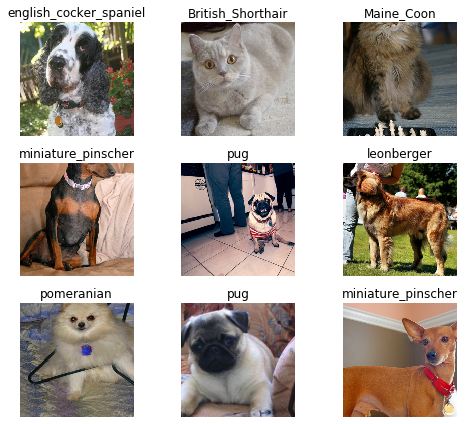

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

It is important to know that `data.c` is a really important piece of information that is something like, or at least for classification problems it is, the number of classes. 

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. 

We will train for 4 epochs (4 cycles through all our data).

 - **DataBunch**: A general fastai concept for your data, and from there, there are subclasses for particular applications like ImageDataBunch
 - **Learner**: A general concept for things that can learn to fit a model. From that, there are various subclasses to make things easier in particular, there is a convnet learner  (something that will create a convolutional neural network for you).

In [14]:
# downloads and instanciates the model
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

* `data`: What's your data. Not surprisingly, it takes a data bunch.
* `arch`: What's your architecture. There are lots of different ways of constructing a convolutional neural network.

In [15]:
# This shows the model
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

So now we have a ConvLearner, we can fit it. You can just use a method called `fit` but in practice, you should nearly always use a method called `fit_one_cycle`. 

In short, one cycle learning is [a paper](https://arxiv.org/pdf/1803.09820.pdf) that was released in April and turned out to be dramatically better both more accurate and faster than any previous approach. Again, I don't want to teach you how to do 2017 deep learning. In 2018/19, the best way to fit models is to use something called one cycle. 

In [ ]:
# Trains the model for 4 epochs
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time


We just trained a model. We don't know exactly what that involved or how it happened but we do know that with 3 or 4 lines of code, we've built something which smashed the accuracy of the state-of-the-art of 2012. 6% error certainly sounds like pretty impressive for something that can recognize different dog breeds and cat breeds, but we don't really know why it work, but we will. That's okay.

In [ ]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. 
* We will try to see if what the model predicted was reasonable or not. 
    * In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Plot the confusion matrix, we can see that the distribution is heavily skewed: 
* the model makes the same mistakes over and over again but it rarely confuses other categories. 
* This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

What we really want to do is to go back and train the whole model. This is why we pretty much always use this two stage process. 
* By default, when we call `fit` or `fit_one_cycle` on a ConvLearner, it'll just fine-tune these few extra layers added to the end and it will run very fast. 
* It will basically never overfit but to really get it good, you have to call `unfreeze`. `unfreeze` is the thing that says please train the whole model. Then I can call fit_one_cycle again.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

## This got much worse, why? 

* We tried to update the whole model with the same big learning rate. 

There is a [a fantastic paper](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) by Matt Zeiler. 
* They wrote a paper showing how you can visualize the layers of a convolutional neural network. A convolutional neural network, which we will learn mathematically about what the layers 
* ResNet34 has 34 layers, and ResNet50 has 50 layers, but let's look at layer one. There's this very simple computation which is a convolution if you know what they are. 
* What comes out of this first layer? Well, we can actually visualize these specific coefficients, the specific parameters by drawing them as a picture. 

In [ ]:
learn.load('stage-1');

In [ ]:
learn.lr_find()

This will plot the result of our LR finder and what this basically shows you is this key parameter called a learning rate. 
* The learning rate basically says how quickly am I updating the parameters in my model. 
* The x-axis one here shows me what happens as I increase the learning rate. The y axis show what the loss is. 

* So you can see, once the learning rate gets passed 10^-4, my loss gets worse. It actually so happens, in fact I can check this if I press <kbd>shift</kbd>+<kbd>tab</kbd> here, my learning defaults to 0.003.
* So you can see why our loss got worse. Because we are trying to fine-tune things now, we can't use such a high learning rate. 
* So based on the learning rate finder, I tried to pick something well before it started getting worse. So I decided to pick `1e-6`. 
    * But there's no point training all the layers at that rate, because we know that the later layers worked just fine before when we were training much more quickly. 
    * So what we can actually do is we can pass a range of learning rates to `learn.fit_one_cycle`. And we do it like this:

In [ ]:
learn.recorder.plot()

You use this keyword in Python called `slice` and that can take a start value and a stop value and basically what this says is train the very first layers at a learning rate of 1e-6, and the very last layers at a rate of 1e-4, and distribute all the other layers across that (i.e. between those two values equally). 

A good rule of thumb is after you unfreeze (i.e. train the whole thing), pass a max learning rate parameter, pass it a slice, make the second part of that slice about 10 times smaller than your first stage. 
* Our first stage defaulted to about 1e-3 so it's about 1e-4. 
* The first part of the slice should be a value from your learning rate finder which is well before things started getting worse. So you can see things are starting to get worse

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. You can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE, force_download=True); path

# Scenario 1: Labels are folder names

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

# Scenario 2: CSV file

In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

# Scenario 3: Using regular expression

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

# Scenario 4: Something more complex

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

# Scenario 5: You need something even more flexible

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

# Creating your own dataset from Google Images

Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. 

**Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In this case we are going to make a teddy bear classifier

In [ ]:
from fastai.vision import *

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

## Download images

In [ ]:
folder = 'black'
file = 'black.csv'

path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

download_images(file, dest, max_pics=200, max_workers=0)

In [ ]:
folder = 'teddys'
file = 'teddys.csv'

path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

download_images(file, dest, max_pics=200, max_workers=0)

In [ ]:
folder = 'grizzly'
file = 'grizzly.csv'

path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

download_images(file, dest, max_pics=200, max_workers=0)

In [ ]:
path = Path('data/bears')
path.ls()

In [ ]:
classes = ['teddys','grizzly','black']

Then we can remove any images that can't be opened:
* It is a godo habit to verify that all your data is complete and good so things do not break
    * One bad piece of information can break your entire model.

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500, max_workers=0)

## View data

* This will create an image bunch
* Will also normalize the data based on image net stats
* This will also make the test train split 

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=16).normalize(imagenet_stats)

**That was simple**

## Let's look at some pixels

In [ ]:
data.classes

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

1. list the classes
2. The number of classes
3. The size of the training data
4. The size of the validation data set

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

## Train model

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [ ]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .split_none()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

Then we create a new learner to use our new databunch with all the images.

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via [/tree](/tree), not [/lab](/lab). Running the `ImageCleaner` widget in Jupyter Lab is [not currently supported](https://github.com/fastai/fastai/issues/1539).

In [ ]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)


If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.


Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
img = open_image(path/'black'/'00000021.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

### Learning rate (LR) too low

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))